# RNN for music generation

# 0. Context

We'll implement a recurrent neural network for the generation of music, following the work presented in [JamBot: Music Theory Aware Chord Based Generation of Polyphonic Music with LSTMs, by Gino Brunner, Yuyi Wang, Roger Wattenhofer and Jonas Wiesendanger](https://arxiv.org/pdf/1711.07682.pdf).
Some parts of the code attached is taken from the repository of the authors of the paper. 
We'll build a LSTM network to generate chords from MIDI files. Finally, we'll use the embedding layer of the model to project the chords in 2D and visualize the concept of word2vec: we'll se that the model has learned the Circle of Fifths.

# 1. Data processing

### Import of necessary modules

In [ ]:
!pip install pretty_midi==0.2.8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
%cd /content/drive/MyDrive/DL/PEC3_PAC3

/content/drive/MyDrive/DL/PEC3_PAC3


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
import pretty_midi as pm
import mido
from collections import Counter
import collections
import pandas as pd

The following modules are taken from the repo of the paper

In [9]:
from settings import *
import midi_functions as mf 
import data_processing_functions as dpf

## Midi files

In this section we'll see the structure of a MIDI file. (I followed this [tutorial](https://www.tensorflow.org/tutorials/audio/music_generation).)

We take a MIDI file from the data and create the functions to extract the notes, the time in which they are played, and their duration. We apply this process only to the **"Acoustic Grand Piano"** instrument.

In [ ]:
midi_path= 'data/original/'
filenames=os.listdir(midi_path)
pm_list=[]
for file in filenames:
  pm_list.append(pm.PrettyMIDI(midi_path+str(file)))

In [11]:
from pretty_midi.utilities import program_to_instrument_name

def find_instrument(instrument):
  for p in pm_list:
    for i,inst in enumerate(p.instruments):
      if program_to_instrument_name(inst.program)==instrument:
        return i,p #i is the position relative to the searched instrument in the list of instruments of p

find_instrument("Acoustic Grand Piano")

(0, <pretty_midi.pretty_midi.PrettyMIDI at 0x7fe7b6856450>)

In [12]:
def midi_to_notes(instrument_number, midi_file) -> pd.DataFrame:
  instrument = midi_file.instruments[instrument_number]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    #notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [13]:
instrument_number, midi_file = find_instrument("Acoustic Grand Piano")
raw_notes=midi_to_notes(instrument_number, midi_file)
raw_notes.head()

,pitch,start,step,duration
0,65,1.983468,0.000000,0.079545
1,69,1.983468,0.000000,0.079545
2,35,1.983468,0.000000,0.088843
3,35,2.148757,0.165289,0.084711
4,69,2.148757,0.000000,0.085744


In [14]:
get_note_names = np.vectorize(pm.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F4', 'A4', 'B1', 'B1', 'A4', 'F4', 'B1', 'A4', 'F4', 'B1'],
      dtype='<U3')

In [15]:
def plot_piano_roll(notes: pd.DataFrame, max_time):
  if max_time==-1:
    title = f'Whole track'
    max_time = list(notes['start'])[-1]+list(notes['duration'])[-1]
  else:
    title = f'First {max_time} seconds'
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['start']+notes['duration']], axis=0)
  plt.plot(
      plot_start_stop[:, :], plot_pitch[:, :], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  plt.xlim([0, max_time])
  _ = plt.title(title)

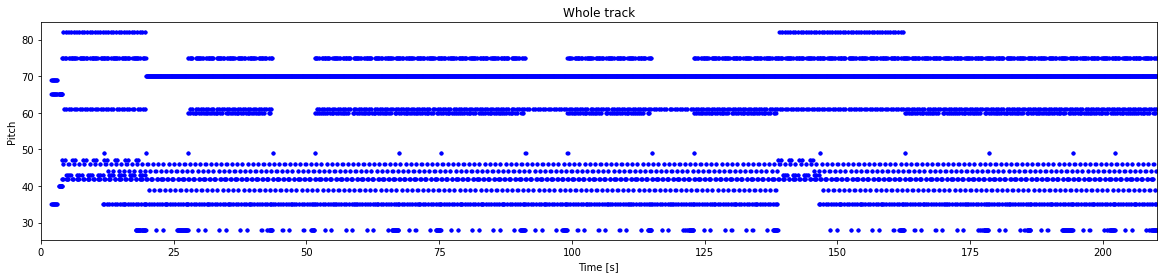

In [11]:
plot_piano_roll(raw_notes, max_time=-1)

### Reproduce a song with fluidsynt

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [16]:
_SAMPLING_RATE = 16000
def display_audio(pm: pm.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
!pip install pretty_midi #I reinstall it to make fluidsynth work

In [22]:
import fluidsynth
import pathlib
import pretty_midi

from IPython import display

In [20]:
p_m = pm_list[0]
display_audio(p_m)

## Data processing

The change_tempo_folder function calls change_tempo on every file in the source folder.

The change_tempo function takes a MIDI file, and outputs a new MIDI file with the tempo changed and/or the time discretized.
In particular the tempo is set to MIDI default, which is 500000 microseconds per beat (120 bpm).

In [ ]:
dpf.do_all_steps()

changing Tempo
histogramming
data/tempo/


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


make song histo
shifting midi files
making note indexes
histogramming
data/shifted/tempo/
extracting chords
getting dictionary
converting chords to index sequences
done


In [ ]:
def my_save_histo_oct_from_midi_folder(tempo_folder,histo_folder):
    total_histo_bar = [0]*128
    total_histo_oct = [0]*12
    print(tempo_folder)
    nfiles=0
    for path, subdirs, files in os.walk(tempo_folder):
        for name in files:
            _path = path.replace('\\', '/') + '/'
            _name = name.replace('\\', '/')
            target_path = histo_folder+_path[len(tempo_folder):]
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            try:
                nfiles+=1
                if nfiles%100==0:
                  print("File #",nfiles,"Current file = ",_path,"/",_name) 
                
                pianoroll, histo_oct = my_midi_to_histo_oct(samples_per_bar,
                                                               octave, fs, _name, _path, target_path)
                
                total_histo_bar += np.sum(pianoroll, axis=1)
                total_histo_oct += np.sum(histo_oct, axis=1)

            except (ValueError, EOFError, IndexError, OSError, KeyError, ZeroDivisionError) as e:
                exception_str = 'Unexpected error in ' + name  + ':\n', e, sys.exc_info()[0]
                print(exception_str)
    return total_histo_bar, total_histo_oct

def my_midi_to_histo_oct(samples_per_bar,octave, fs, name, path, histo_path):
    pianoroll = mf.get_pianoroll(name, path, fs)
    histo_bar = mf.pianoroll_to_histo_bar(pianoroll, samples_per_bar)
    histo_oct = mf.histo_bar_to_histo_oct(histo_bar, octave)
    return pianoroll, histo_oct


h_bar, h_oct = my_save_histo_oct_from_midi_folder(tempo_folder1,histo_folder1)

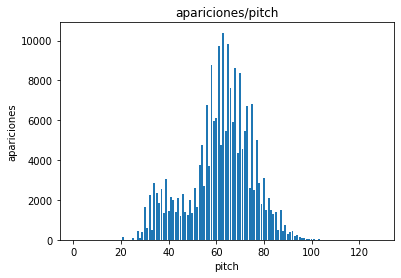

In [ ]:
plt.bar(range(1,129), h_bar)
plt.title('apariciones/pitch');
plt.ylabel('apariciones');
plt.xlabel('pitch');

In [ ]:
notas_en_una_octava = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

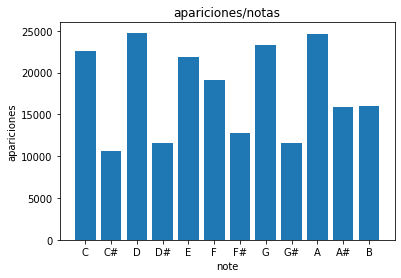

In [ ]:
plt.bar(notas_en_una_octava, h_oct)
plt.title('apariciones/notas')
plt.ylabel('apariciones')
plt.xlabel('note');

The 7 most played notes are C D E F G A and one of A# and B that have a really similar frequency. \
The notes C D E F G A B compose the C major scale. \
The notes C D E F G A A# compose the F major scale (F G A A# C D E).

# 2. LSTM for chords

We'll train the LSTM with a smaller dataset, we'll compare the performance of this model with the one trained in the attached paper.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras.utils
from keras.utils import np_utils
from random import shuffle
import progressbar
import time

## 2.1 Data loading

2.1.1 In the ***data*** folder we can find a file called ***dataset.pkl*** containing 11338 train song and 3780 test songs.
Using pickle we load these songs and we'll use just 2000 for training and 500 for test.

In [ ]:
train_set_size=2000
test_set_size=500
dataset = pickle.load(open('/content/drive/MyDrive/DL/PEC3_PAC3/data/dataset.pkl', "rb"))
#dataset is a list of 2 lists: train (0) and test (1)
train_set=dataset[0][:train_set_size]
test_set=dataset[1][:test_set_size]

## 2.2 Model with an Embedding Layer

In [ ]:
batch_size = 1
step_size = 1
epochs = 10

lstm_size = 128 #in the article it is 256, on github it is 512
learning_rate = 0.00001
optimizer = 'Adam'

The code in the next block was given to me by the professor of the Deep Learning course to preserve the structure of the folder since there is a lot of the code from the paper repository that depends on this structure:

In [ ]:
base_path = 'models/chords/'
model_filetype = '.pickle'

shuffle_train_set = True
bidirectional = False

#Create model dir
fd = {'shifted': shifted, 'lr': learning_rate, 'emdim': chord_embedding_dim, 'opt': optimizer,
'bi': bidirectional, 'lstms': lstm_size, 'trainsize': train_set_size, 'testsize': test_set_size, 'samples_per_bar': samples_per_bar}
t = str(np.random.randint(1000,9999))
model_name = t+ '-Shifted_%(shifted)s_Lr_%(lr)s_EmDim_%(emdim)s_opt_%(opt)s_bi_%(bi)s_lstmsize_%(lstms)s_trainsize_%(trainsize)s_testsize_%(testsize)s_samples_per_bar%(samples_per_bar)s' % fd
model_path = base_path + model_name + '/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [ ]:
model = Sequential()
model.add(Embedding(num_chords, chord_embedding_dim, input_length=step_size, name="embedding", batch_input_shape=(batch_size,step_size)))
model.add(LSTM(lstm_size, stateful=True))
model.add(Dense(num_chords))
model.add(Activation('softmax'))

optimizer = Adam(lr=learning_rate)
loss = 'categorical_crossentropy'
print("compiling model")
model.compile(optimizer, loss)

## 2.3 Training

In [ ]:
epoch_array=[]
total_test_loss_array = [] 
total_train_loss_array = []
total_test_loss = 0
show_plot = False
save_plot = True
test_step = 500   
verbose = False
save_step = 1

def test():
    """For each song in the test set we build a sequence of chords X and a sequence of the chords played after each chord of X.
    model.evaluate returns a mesure of how much the prediction of the model differ from the true labels.
    total_test_loss_array is updated appending the total_test_loss at the end of the testing phase.
    test() also plots the evolution of the test_loss and of the train_loss through the epochs (a point each 1/4 of epoch).
    At the end saves the arrays of the train and test loss in two pickle files, and if we want saves also the plot."""

    print('\nTesting:')
    total_test_loss = 0

    bar = progressbar.ProgressBar(maxval=test_set_size, redirect_stdout=False)
    for i, test_song in enumerate(test_set):
        X_test = np.array(test_song[:-1])
        Y_test = np_utils.to_categorical(test_song[1:], num_classes=num_chords)
        loss = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
        model.reset_states()
        total_test_loss += loss
        bar.update(i+1)

    total_test_loss_array.append(total_test_loss/test_set_size)
    print('\nTotal test loss: ', total_test_loss/test_set_size)
    print('-'*50)
    plt.plot(total_test_loss_array, 'b-', label='test loss')
    plt.plot(total_train_loss_array, 'r-', label='train loss')
#    plt.legend()
    plt.ylabel(model_path)
#    plt.axis([0, 50, 3, 5])
    plt.grid()
    if show_plot: plt.show()
    if save_plot: plt.savefig(model_path+'plot.png')
    #pickle.dump(epoch_array,open(model_path+'epoch_array.pickle', 'wb'))
    pickle.dump([epoch_array,total_test_loss_array],open(model_path+'total_test_loss_array.pickle', 'wb'))
    pickle.dump([epoch_array,total_train_loss_array],open(model_path+'total_train_loss_array.pickle', 'wb'))



def train():
    """for each epoch, loops on each song of the train set and fits the model with the chords in the array X and 
    their respective labels (the chord played after each element of X). Then reset_states() resets the memory of 
    the model so that we can feed it a new sequence to be trained on.
    Once we have completed "test_step" steps we update total_train_loss_array and total_test_loss_array, calling test(). 
    At the end of each epoch we save the model so that we can load it in the future without having to re-train it"""

    print('training model...')
    total_train_loss = 0
    for e in range(1, epochs+1):
        print('Epoch ', e, 'of ', epochs, 'Epochs\nTraining:')
        if shuffle_train_set:
            shuffle(train_set)
        bar = progressbar.ProgressBar(maxval=train_set_size)
        for i, song in enumerate(train_set):
            # bar.start()
            X = np.array(song[:-1])
            Y = np_utils.to_categorical(song[1:], num_classes=num_chords)
            hist = model.fit(X, Y, batch_size=batch_size, shuffle=False, verbose=verbose)
            model.reset_states()
            bar.update(i+1)
#            print(hist.history)
            total_train_loss += hist.history['loss'][0]
            if (i+1)%test_step is 0:
                epoch=(e-1)+(i+1)/len(train_set)
                epoch_array.append(epoch)
                total_train_loss = total_train_loss/test_step
                total_train_loss_array.append(total_train_loss)
                test()
                total_train_loss = 0
        if e%save_step is 0:
            print('saving model')
            model_save_path = model_path + 'model_' + 'Epoch' + str(e) + '_' + str(i+1) + model_filetype
            model.save(model_save_path)
    plt.legend(['test', 'train'])

def save_params():
    """stores the parameters used for the model and the training in a file so that we can retrieve this info if we need it"""
  
    with open(model_path + 'params_0.txt', "w") as text_file:
        text_file.write("epochs: %s" % epochs + '\n')
        text_file.write("train_set_size: %s" % train_set_size + '\n')
        text_file.write("test_set_size: %s" % test_set_size + '\n')
        text_file.write("lstm_size: %s" % lstm_size + '\n')
        text_file.write("embedding_dim: %s" % chord_embedding_dim + '\n')
        text_file.write("learning_rate: %s" % learning_rate + '\n')
        #text_file.write("save_step: %s" % save_step + '\n')
        text_file.write("shuffle_train_set: %s" % shuffle_train_set + '\n')
        text_file.write("test_step: %s" % test_step + '\n')
        text_file.write("bidirectional: %s" % bidirectional + '\n')
        text_file.write("num_chords: %s" % num_chords + '\n')
        text_file.write("chord_n: %s" % chord_n + '\n')

- X is an array of the elements that constitute the sequence of chords of the selected song, from the first to the one before the last chord.
- The label for each element of X is the chord played after it. This is why we don't put the last chord of the song as element of X: it won't have a label to be associated with.
- categorical_crossentropy is used in multi-class classification tasks when the labels are represented as one-hot arrays. Here we want to predict which one of the many chords is played next: we predict a label between many. Y is built with to_categorical so it's a one-hot encoding.
- The network is learning which chord is more likely to be played given the list of chords played previously.

In [ ]:
print("saving params")
save_params()
print("starting training..")
train()

In [ ]:
#test model with smaller train and test size
path_3963='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/3963-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_20_testsize_5_samples_per_bar8'
model.save(path_3963+'/my_model')

In [ ]:
#retrieve train_loss and test_loss of the model with small train set

filename_train='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/3963-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_20_testsize_5_samples_per_bar8/total_train_loss_array.pickle'
with open(filename_train, 'rb') as f:
    train_loss_3963 = pickle.load(f)

filename_test='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/3963-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_20_testsize_5_samples_per_bar8/total_test_loss_array.pickle'
with open(filename_test, 'rb') as f:
    test_loss_3963 = pickle.load(f)

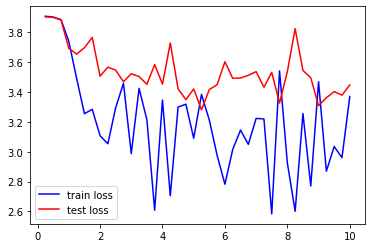

In [ ]:
#plot of train and test loss of the small model

epoch_array_3963, total_train_loss_array_3963 = train_loss_3963[0], train_loss_3963[1]
total_test_loss_array_3963 = test_loss_3963[1]
plt.plot(epoch_array_3963, total_train_loss_array_3963, 'b-', label='train loss')
plt.plot(epoch_array_3963, total_test_loss_array_3963, 'r-', label='test loss')
plt.legend();

## 2.4 Comparison between the models

Here we compare different models. In the folder *models/chords* we can find the pretrained model folder: 5102-Shifted_True_...

In [ ]:
def plot_loss(model_path):
  with open(model_path+'/params_0.txt', 'r') as f:
    print('Parameters:')
    for line in f.readlines(): 
      print(line)

  try:
    with open(model_path+'/total_test_loss_array.pickle', 'rb') as f:
      total_test_loss_array = pickle.load(f)
  except:
    print('some error occurred while unpickling _test')
    total_test_loss_array=[[],[]]
  try:
    with open(model_path+'/total_train_loss_array.pickle', 'rb') as f:
      total_train_loss_array = pickle.load(f)
  except:
    print('some error occurred while unpickling _train')
    total_train_loss_array=[[],[]]
  plt.plot(total_train_loss_array[0], total_train_loss_array[1], 'r-', label='train loss')
  plt.plot(total_test_loss_array[0], total_test_loss_array[1], 'b-', label='test loss')
  plt.legend()

  print('min train_loss: ', min(total_train_loss_array[1]))
  print('last epoch train_loss: ', total_train_loss_array[1][-1])
  print('')
  print('min test_loss: ', min(total_test_loss_array[1]))
  print('last epoch test_loss: ', total_test_loss_array[1][-1])

Parameters:
epochs: 10

train_set_size: 20

test_set_size: 5

lstm_size: 256

embedding_dim: 10

learning_rate: 1e-05

shuffle_train_set: True

test_step: 5

bidirectional: False

num_chords: 50

chord_n: 3

min train_loss:  2.582868242263794
last epoch train_loss:  3.370318126678467

min test_loss:  3.2802754402160645
last epoch test_loss:  3.447358226776123


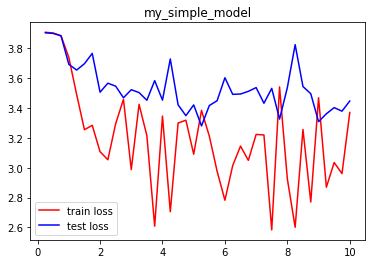

In [ ]:
#my model with just 20 train instances

model_path='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/3963-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_20_testsize_5_samples_per_bar8'
plt.title('my_simple_model')
plot_loss(model_path)

Parameters:
epochs: 10

train_set_size: 2000

test_set_size: 500

lstm_size: 128

embedding_dim: 10

learning_rate: 1e-05

shuffle_train_set: True

test_step: 500

bidirectional: False

num_chords: 50

chord_n: 3

min train_loss:  2.6557637543678285
last epoch train_loss:  2.6816530890464785

min test_loss:  2.908185363650322
last epoch test_loss:  2.908185363650322


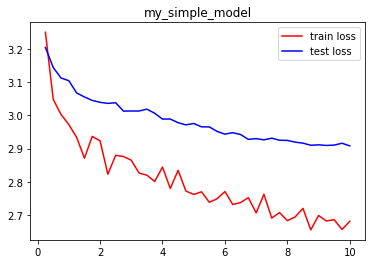

In [ ]:
#my model with train set size = 2000 and test set size = 500

model_path='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/2418-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8'
plt.title('my_simple_model')
plot_loss(model_path)

Parameters:
epochs: 20

train_set_size: 4000

test_set_size: 1000

lstm_size: 256

embedding_dim: 10

learning_rate: 1e-05

shuffle_train_set: True

test_step: 1000

bidirectional: False

num_chords: 50

chord_n: 3

min train_loss:  2.417042148053646
last epoch train_loss:  2.417042148053646

min test_loss:  2.690847583383322
last epoch test_loss:  2.690847583383322


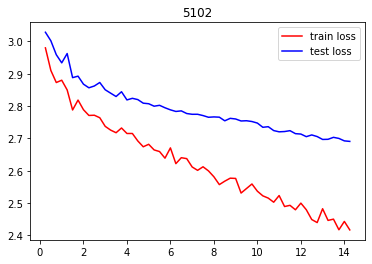

In [ ]:
#5102

model_path='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8'
plt.title('5102')
plot_loss(model_path)


In [ ]:
with open('/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/2717-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_2000_testsize_500_samples_per_bar8/params_0.txt', 'r') as f:
    print('Parameters:')
    for line in f.readlines(): 
      print(line)

print('2717 train_loss_array:')

filename='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/2717-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_2000_testsize_500_samples_per_bar8/total_train_loss_array.pickle'

#test:
#filename='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/2717-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_2000_testsize_500_samples_per_bar8/total_test_loss_array.pickle'

with open(filename, 'rb') as f:
    y = pickle.load(f)

print(y[1])
print('')
print('min train_loss: ', min(y[1]))
print('last epoch train_loss: ', y[1][-1])

Parameters:
epochs: 10

train_set_size: 2000

test_set_size: 500

lstm_size: 256

embedding_dim: 10

learning_rate: 1e-05

shuffle_train_set: True

test_step: 500

bidirectional: False

num_chords: 50

chord_n: 3

2717 train_loss_array:
[3.2067090344429015, 3.056456005334854, 3.00550487947464, 2.9178928594589233, 2.896643443584442, 2.887987513780594, 2.8676632087230685, 2.87538449883461, 2.8309347591400145, 2.847584739923477, 2.8131260049343108, 2.780345030069351, 2.758235659599304, 2.7470233235359194, 2.8071637678146364, 2.769978053331375, 2.7565401213169096, 2.7289679214954377, 2.751720237493515, 2.7140890004634857, 2.669332010149956, 2.7360239028930664, 2.7322815084457397, 2.682753571510315, 2.6576193645000457, 2.6754649229049683, 2.6891631581783293, 2.6794152958393096, 2.6425937898159026, 2.6837377827167512, 2.6542356216907503, 2.621161705851555, 2.630433811903, 2.620609693527222, 2.591661794900894, 2.6580298743247988, 2.5861199698448183, 2.6075632679462433, 2.6108317116498947, 2.5

- The set of parameters that gives the best performance is the one of the model 5102: 

Parameters:

epochs: 20

train_set_size: 4000

test_set_size: 1000

lstm_size: 256

embedding_dim: 10

learning_rate: 1e-05

shuffle_train_set: True

test_step: 1000

bidirectional: False

num_chords: 50

chord_n: 3

This model reaches a loss on the test set of 2.690847583383322, that is the smaller between the test losses of the models that we have.

- The models are not overfitting on the training data: we can see it from the plot of the loss on the test set (blue line) that is monotonically decreasing for all the models.
(From the parameters of model 5102 we can see that it should have 20 epochs, it may be that we only have 14 because it was trained with early stopping and it was seen that after the 14th epoch the model started overfitting)

# 3 Embedding layer analysis

In [ ]:
from keras.models import load_model
import keras
from keras import backend as K

We'll load the model we trained (my_model) and the pretrained model with the best performance (bp_model)

In [ ]:
my_simple_model_path='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/3963-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_20_testsize_5_samples_per_bar8/my_model'
my_simple_model=load_model(my_simple_model_path)

In [ ]:
my_model_path='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/2418-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch10_2000.pickle'
my_model=load_model(my_model_path)

In [ ]:
bp_model_path='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/model_Epoch14_4000.pickle'
bp_model=load_model(bp_model_path)

We create, for each model, a new model for the embeddings: a model that has he same input of the original models and as output the embedding layer.

In [ ]:
inputs = my_model.input
outputs = my_model.get_layer(name="embedding").output
embedding_my_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
inputs_bp = bp_model.input
outputs_bp = bp_model.get_layer(name="embedding").output
embedding_bp_model = tf.keras.Model(inputs=inputs_bp, outputs=outputs_bp)

The embedding model receives a chord and outputs a vector of dimension = 10 with the embedding of that chord. 

In [ ]:
my_chords_embeddings = []
for i in range(0,50):
  my_chords_embeddings.append(embedding_my_model.predict([i]))
np_my_chords_embeddings=np.array(my_chords_embeddings)

In [ ]:
bp_chords_embeddings = []
for i in range(0,50):
  bp_chords_embeddings.append(embedding_bp_model.predict([i]))
np_bp_chords_embeddings=np.array(bp_chords_embeddings)

In [ ]:
squeezed_np_my = np.squeeze(np_my_chords_embeddings)
squeezed_np_bp = np.squeeze(np_bp_chords_embeddings)

## 3.2 PCA analysis


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
ss=StandardScaler()
standard_my = ss.fit_transform(squeezed_np_my)
standard_bp = ss.fit_transform(squeezed_np_bp)

pca = PCA(n_components = 2)
my_chords_2d = pca.fit_transform(standard_my)
bp_chords_2d = pca.fit_transform(standard_bp)

In [ ]:
def get_chord_dict():
    chord_to_index = pickle.load(open(dict_path + chord_dict_name, 'rb'))
    index_to_chord = pickle.load(open(dict_path + index_dict_name, 'rb'))
    return chord_to_index, index_to_chord

chord_to_index, idx_2_chord = get_chord_dict()

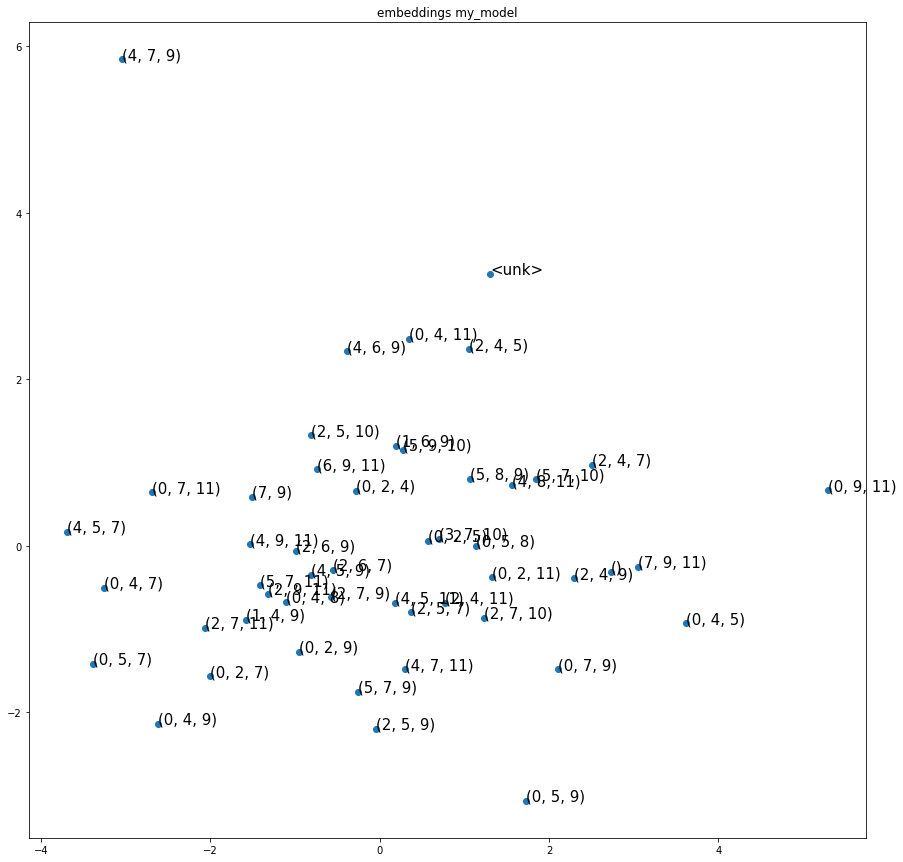

In [ ]:
x_my, y_my = my_chords_2d[:,0], my_chords_2d[:,1]

plt.figure(figsize=(15,15))
plt.scatter(x_my, y_my)
plt.title('embeddings my_model')

for i in range(0,50):
    plt.annotate(idx_2_chord[i], (x_my[i], y_my[i]), size=15)

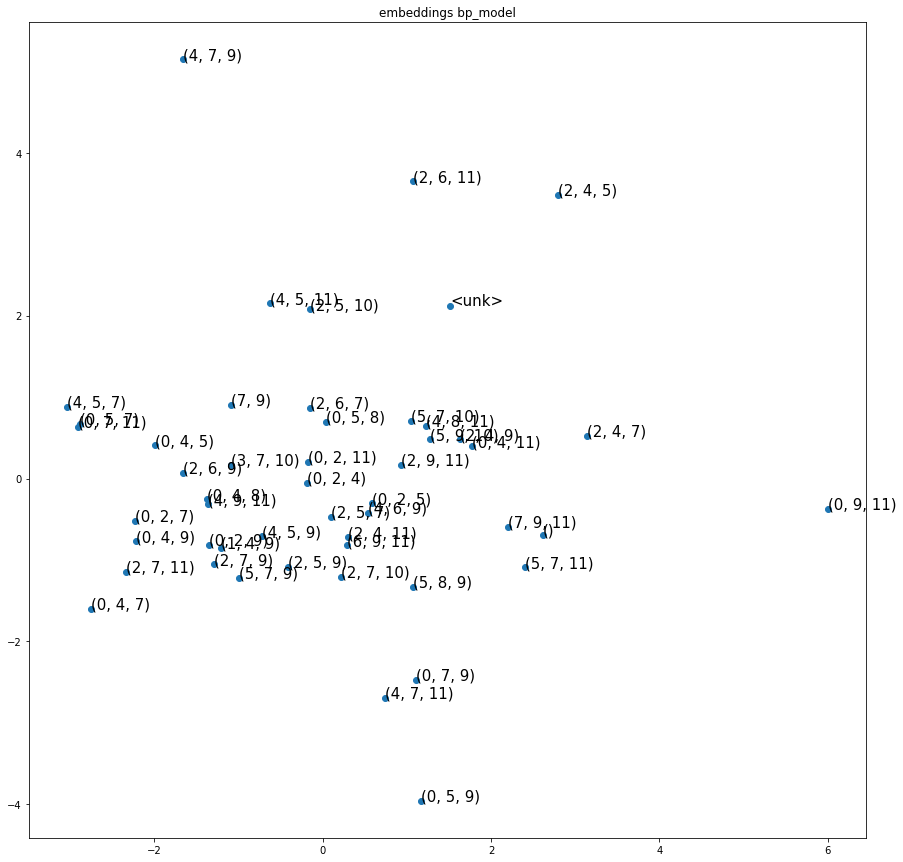

In [ ]:
x_bp, y_bp = bp_chords_2d[:,0], bp_chords_2d[:,1]

plt.figure(figsize=(15,15))
plt.scatter(x_bp, y_bp)
plt.title('embeddings bp_model')

for i in range(0,50):
    plt.annotate(idx_2_chord[i], (x_bp[i], y_bp[i]), size=15)

The embeddings found are pretty similar. We can clearly see the effect of word2vec: chords with notes in common are closer than chords without notes in common.
For instance we can observe that in the left part of both plots there are chords with the notes 0 and 7, moving to the right we can see more often the notes 9 and 11.

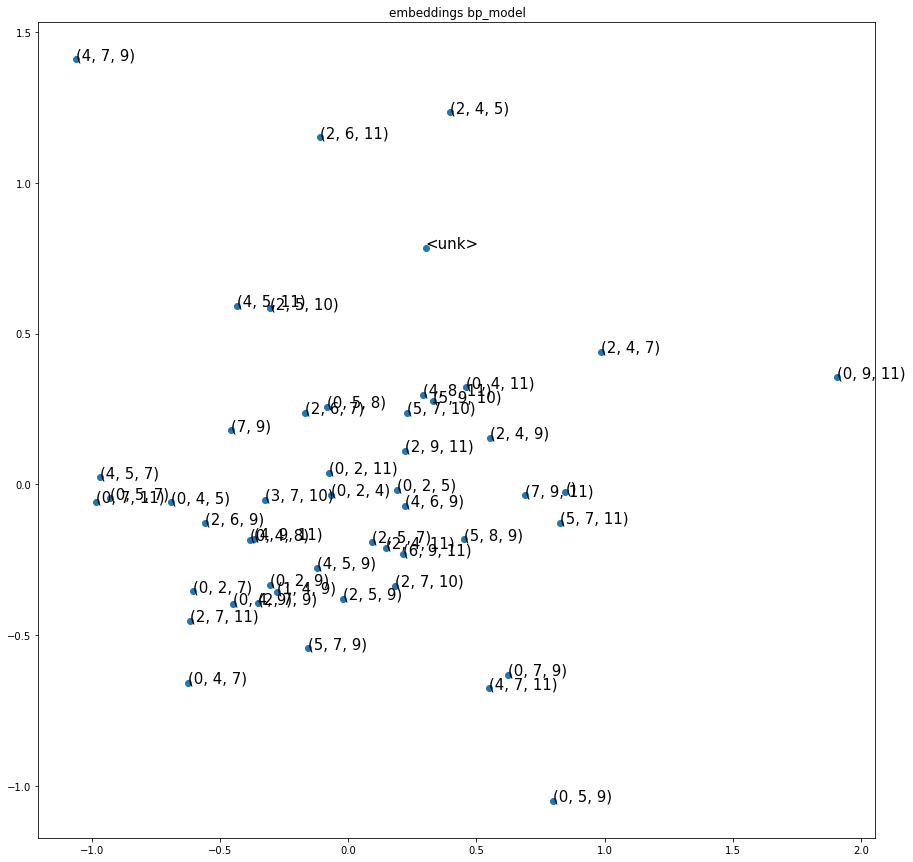

In [ ]:
#just a test to see the plot without the standardization

bp_chords_2d_noss = pca.fit_transform(squeezed_np_bp)
x_bp_noss, y_bp_noss = bp_chords_2d_noss[:,0], bp_chords_2d_noss[:,1]

plt.figure(figsize=(15,15))
plt.scatter(x_bp_noss, y_bp_noss)
plt.title('embeddings bp_model')

for i in range(0,50):
    plt.annotate(idx_2_chord[i], (x_bp_noss[i], y_bp_noss[i]), size=15)

We'll calculate the distance between the first 20 chords. We'll analyze the 10 smallest distances for both models.

In [ ]:
def distance(chord1, chord2):
  #10 dimensional euclidean distance
  return np.sqrt(np.sum((chord1 - chord2)**2))

def dist_20(model):
  distances={}
  if model=='my_model':
    chords = standard_my
  else:
    chords = standard_bp
  for i in range(0,19):
    for j in range(i+1,20):
        distances[(i,j)] = distance(chords[i], chords[j])
  return distances


from heapq import nsmallest

def smallest_distances_keys(n, distances):
  smallest_values_keys = nsmallest(n, distances, key = distances.get)
  return smallest_values_keys

In [ ]:
distances_bp = dist_20('bp_model')
keys_bp = smallest_distances_keys(10, distances_bp)
print('10 closest chords for bp_model embedding')
for k in keys_bp:
  print(idx_2_chord[k[0]], idx_2_chord[k[1]], ' : ', distances_bp.get(k))

10 closest chords for bp_model embedding
(0, 5, 7) (0, 2, 7)  :  1.7065985
(2, 5, 9) (2, 5, 7)  :  1.7177365
(0, 2, 7) (1, 4, 9)  :  1.8573223
(0, 2, 7) (0, 4, 5)  :  1.9817382
(0, 5, 7) (0, 4, 5)  :  2.044014
(0, 4, 5) (1, 4, 9)  :  2.0795894
(2, 7, 9) (1, 4, 9)  :  2.1073396
(2, 7, 9) (0, 4, 5)  :  2.145992
(0, 5, 9) (4, 7, 11)  :  2.1538844
(0, 2, 7) (2, 7, 9)  :  2.291703


In [ ]:
distances_my = dist_20('my_model')
keys_my = smallest_distances_keys(10, distances_my)
print('10 closest chords for my_model embedding')
for k in keys_my:
  print(idx_2_chord[k[0]], idx_2_chord[k[1]], ' : ', distances_my.get(k))

10 closest chords for my_model embedding
(0, 2, 7) (1, 4, 9)  :  1.4707278
(0, 2, 7) (5, 7, 11)  :  1.9582353
(0, 7, 9) ()  :  2.0414307
(5, 7, 11) (1, 4, 9)  :  2.0610917
(2, 5, 9) (2, 5, 7)  :  2.1030025
(2, 7, 9) (0, 2, 9)  :  2.1191866
(5, 7, 9) (2, 5, 7)  :  2.2456887
(0, 5, 7) (0, 2, 7)  :  2.2818172
(2, 7, 9) (1, 4, 9)  :  2.292082
(0, 2, 7) (2, 7, 9)  :  2.3121939


Most of the chords with minimal distance have at least one note in common and many have 2 notes in common. 

The couples   
(0, 2, 7) (1, 4, 9)  
(0, 2, 7) (0, 4, 5)  
(0, 4, 5) (1, 4, 9)  
(2, 7, 9) (1, 4, 9)  
(2, 7, 9) (0, 4, 5)  
(0, 2, 7) (2, 7, 9)

are interesting since they form a cluster of chords all similar (close) to each other.

# 4. Circle of Fifths

We'll use the data from *models/chords/9671-Shifted_False...* to repeat the process of PCA anaylis.

In [ ]:
model_9671_path='/content/drive/MyDrive/DL/PEC3_PAC3/models/chords/9671-Shifted_False_Lr_1.5e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/model_Epoch8_4000.pickle'
model_9671=load_model(model_9671_path)

inputs_9671 = model_9671.input
outputs_9671 = model_9671.get_layer(name="embedding").output
embedding_model_9671 = tf.keras.Model(inputs=inputs_9671, outputs=outputs_9671)

chords_embeddings_9671 = []
for i in range(0,50):
  chords_embeddings_9671.append(embedding_model_9671.predict([i]))
np_9671_chords_embeddings = np.array(chords_embeddings_9671)

squeezed_np_9671 = np.squeeze(np_9671_chords_embeddings)

ss=StandardScaler()
standard_9671 = ss.fit_transform(squeezed_np_9671)

pca = PCA(n_components = 2)
chords_2d_9671 = pca.fit_transform(standard_9671)

In [ ]:
def get_chord_dict_no_shifted():
    chord_to_index = pickle.load(open('data/chord_dict.pickle', 'rb'))
    index_to_chord = pickle.load(open('data/index_dict.pickle', 'rb'))
    return chord_to_index, index_to_chord

chord_to_index_, idx_2_chord_ = get_chord_dict_no_shifted()

In [ ]:
ddd={tuple((0,4,7)):'C',
tuple((1,5,8)):'C#',
tuple((2,6,9)):'D',
tuple((3,7,10)):'D#',
tuple((4,8,11)):'E',
tuple((0,5,9)):'F',
tuple((1,6,10)):'F#',
tuple((2,7,11)):'G',
tuple((0,3,8)):'G#',
tuple((1,4,9)):'A',
tuple((2,5,10)):'A#',
tuple((3,6,11)):'B'}


def plot_5th_circle(X_chords_2d):
  
  fig, ax = plt.subplots()
  fig.set_size_inches(8, 6)

  plt.tick_params(labelsize=12)
  
  style = dict(size=12, color='black')

  for i in range(0,len(idx_2_chord_)):
    try:
      ax.text(-X_chords_2d[i,0]-0.32,X_chords_2d[i,1]+0.11, ddd[idx_2_chord_[i]],**style)
      ax.scatter(-X_chords_2d[i,0],X_chords_2d[i,1], c="blue", marker="*")
      
    except:
      pass

  plt.show()

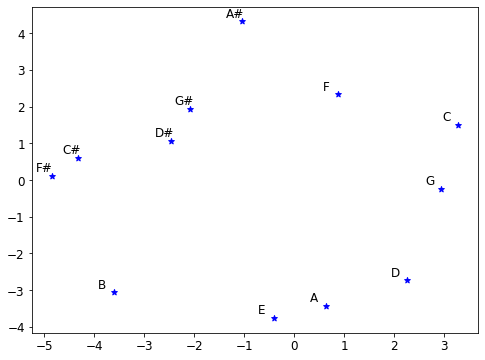

In [ ]:
plot_5th_circle(chords_2d_9671)

The learned embeddings resembles the circle of fifths. The only difference is the order between D# and G#: proceding clockwise in the real circle of fifth G# comes after C# and before D#.